In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import os
from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
import xml.etree.ElementTree as ET
from IPython.display import display, Image
import PIL.Image
from io import BytesIO
import shutil


In [2]:

def unet(pretrained_weights = None, input_size = (256,256,1)):
    inputs = tf.keras.layers.Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(2, 1)(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    return model


In [3]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]


In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [5]:
def show_image(img, fmt='png'):
    a = np.uint8(img)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def xml_to_coordinates(t):
    result = []
    for p in t.split(' '):
        values = p.split(',')
        assert len(values) == 2
        x, y = int(float(values[0])), int(float(values[1]))
        result.append((x,y))
    result=np.array(result)
    return result

def page_mask_from_page_path_and_mask_text(page_image_path, page_xml_path, mask_text):
    page_image = cv2.imread(page_image_path,0)
    page_height, page_width = page_image.shape
    page_mask = np.zeros((page_height, page_width), np.uint8)

    tree = ET.parse(page_xml_path)
    root = tree.getroot()
    words = root.findall('{http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15}Page/'+
                         '{http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15}TextRegion/'+
                         '{http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15}TextLine/'+
                         '{http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15}Word')
    for word in words:
        unicode = word.find('{http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15}TextEquiv/'+
                            '{http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15}Unicode')
        word_text = unicode.text
        if word_text == mask_text:
            coords = word.find('{http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15}Coords')
            points = coords.attrib['points']
            cnt = xml_to_coordinates(points)
            (x,y,w,h) = cv2.boundingRect(cnt)
            cv2.rectangle(page_mask, (x,y), (x+w,y+h), (255,255,255), -1)
    page_mask = cv2.bitwise_and(page_image, page_mask)
    #show_image(page_mask)
    page_mask = (page_mask>0).astype('int')
    return page_mask

def book_labels_from_book_path_and_mask_text(book_images_path, book_xmls_path, mask_text, book_labels_path):
    shutil.rmtree(book_labels_path, ignore_errors=True)
    os.makedirs(book_labels_path, exist_ok=True)
    book_images = [f for f in os.listdir (book_images_path) if f.endswith('.png') ]
    for book_image in book_images:
        book_xml = book_image[:-4]+'.xml'
        page_image_path = os.path.join(book_images_path, book_image)
        page_xml_path = os.path.join(book_xmls_path, book_xml)
        page_mask = page_mask_from_page_path_and_mask_text(page_image_path, page_xml_path, mask_text)
        cv2.imwrite(os.path.join(book_labels_path, book_image), page_mask)
    
mask_text = 'ا'   

In [ ]:
book1_images = '../vml_line_dataset/3157556_binary/'
book1_xmls = '../vml_line_dataset/3157556_word_and_line_annotations/'
book1_labels = '3157556_labels/'
book2_images = '../vml_line_dataset/3158466_binary/'
book2_xmls = '../vml_line_dataset/3158466_word_and_line_annotations/'
book2_labels = '3158466_labels/'
book3_images = '../vml_line_dataset/3249138_binary/'
book3_xmls = '../vml_line_dataset/3249138_word_and_line_annotations/'
book3_labels = '3249138_labels/'
book4_images = '../vml_line_dataset/3368132_binary/'
book4_xmls = '../vml_line_dataset/3368132_word_and_line_annotations/'
book4_labels = '3368132_labels/'
book5_images = '../vml_line_dataset/3426930_binary/'
book5_xmls = '../vml_line_dataset/3426930_word_and_line_annotations/'
book5_labels = '3426930_labels/'


book_images = [book1_images]
book_xmls = [book1_xmls]
book_labels = [book1_labels]



for i in range(len(book_images)):   
    book_labels_from_book_path_and_mask_text(book_images[i], book_xmls[i], mask_text, book_labels[i])



In [6]:
align_book1_images = 'book1_binary_images/'
align_book1_xmls = 'book1_words_lines_page_xmls/'
align_book1_labels = 'book1_labels'

align_book2_images = 'book2_binary_images/'
align_book2_xmls = 'book2_words_lines_page_xmls/'
align_book2_labels = 'book2_labels'

align_book_images = [align_book1_images]
align_book_xmls = [align_book1_xmls]
align_book_labels = [align_book1_labels]

for i in range(len(align_book_images)):   
    book_labels_from_book_path_and_mask_text(align_book_images[i], align_book_xmls[i], mask_text, align_book_labels[i])
    

In [35]:
align_book1_images = 'book1_binary_images/'
align_book1_xmls = 'book1_words_lines_page_xmls/'
align_book1_labels = 'book1_labels'

align_book2_images = 'book2_binary_images/'
align_book2_xmls = 'book2_words_lines_page_xmls/'
align_book2_labels = 'book2_labels'

test_align_book_images = [align_book2_images]
test_align_book_xmls = [align_book2_xmls]
test_align_book_labels = [align_book2_labels]

for i in range(len(align_book_images)):   
    book_labels_from_book_path_and_mask_text(test_align_book_images[i], test_align_book_xmls[i], mask_text, test_align_book_labels[i])
    

In [ ]:
image_paths = []
label_paths = []

for i in range(len(book_images)):    
    image_names = [f for f in os.listdir (book_images[i]) if f.endswith('.png')]
    book_root = book_images[i]
    for image_name in image_names:
        image_paths.append(os.path.join(book_root, image_name))
    
    label_names = [f for f in os.listdir (book_labels[i]) if f.endswith('.png')]
    label_root = book_labels[i]
    for label_name in label_names:
        label_paths.append(os.path.join(label_root, label_name))
        


In [7]:
align_image_paths = []
align_label_paths = []

for i in range(len(align_book_images)):    
    image_names = [f for f in os.listdir (align_book_images[i]) if f.endswith('.png')]
    book_root = align_book_images[i]
    for image_name in image_names:
        align_image_paths.append(os.path.join(book_root, image_name))
    
    label_names = [f for f in os.listdir (align_book_labels[i]) if f.endswith('.png')]
    label_root = align_book_labels[i]
    for label_name in label_names:
        align_label_paths.append(os.path.join(label_root, label_name))
        

In [36]:
test_align_image_paths = []
test_align_label_paths = []

for i in range(len(test_align_book_images)):    
    image_names = [f for f in os.listdir (test_align_book_images[i]) if f.endswith('.png')]
    book_root = test_align_book_images[i]
    for image_name in image_names:
        test_align_image_paths.append(os.path.join(book_root, image_name))
    
    label_names = [f for f in os.listdir (test_align_book_labels[i]) if f.endswith('.png')]
    label_root = test_align_book_labels[i]
    for label_name in label_names:
        test_align_label_paths.append(os.path.join(label_root, label_name))

In [8]:
train_align_image_paths = align_image_paths[:int((len(align_image_paths)+1)*.90)]
train_align_label_paths = align_label_paths[:int((len(align_label_paths)+1)*.90)]

test_align_image_paths = align_image_paths[int((len(align_image_paths)+1)*.90):]
test_align_label_paths = align_label_paths[int((len(align_label_paths)+1)*.90):]

In [ ]:
indices = np.arange(len(image_paths))
np.random.shuffle(indices)
image_paths = [image_paths[i] for i in indices]
label_paths = [label_paths[i] for i in indices]

In [ ]:
train_image_paths = image_paths[:int((len(image_paths)+1)*.90)]
train_label_paths = label_paths[:int((len(label_paths)+1)*.90)]

test_image_paths = image_paths[int((len(image_paths)+1)*.90):]
test_label_paths = label_paths[int((len(label_paths)+1)*.90):]

In [9]:
def normalize(input_image):
    # convert from integers to floats
    input_image = input_image.astype('float32')
    # normalize to the range 0-1
    input_image /= 255.0
    return input_image

In [10]:
def get_patch(image_paths, label_paths, patch_size):
    
    while True:
        choice = np.random.choice(len(label_paths))
        label = cv2.imread(label_paths[choice], 0)
        rows, cols = label.shape
        skip = 0
        while True:         
            x = random.randint(0, rows-patch_size)
            y = random.randint(0, cols-patch_size)
            label_patch = label[x:x+patch_size,y:y+patch_size]
            fg = list(label_patch.flatten()).count(1)
            if fg>100:
                image = cv2.imread(image_paths[choice], 0)
                image_patch = image[x:x+patch_size,y:y+patch_size]
                image_patch = normalize(image_patch)
                return image_patch, label_patch
            if skip == 15:
                choice = np.random.choice(len(label_paths))
                label = cv2.imread(label_paths[choice], 0)
                rows, cols = label.shape
                skip = 0
            skip = skip + 1
    
    

In [11]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
    class_weights = tf.constant([1.0, 50.0])
    class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))
    return image, label, sample_weights

In [12]:
class WeightedDataGenerator(Sequence):
    def __init__(self, epoch_size, batch_size, patch_size, set_size, 
                 train_image_paths, train_label_paths):
        self.set_size = set_size
        self.batch_size = batch_size
        self.epoch_size = epoch_size
        self.patch_size = patch_size
        self.image_paths = train_image_paths
        self.label_paths = train_label_paths


    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.set_size / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        image_patches = []
        label_patches = []
        sample_weights = []
        for i in range(self.batch_size):
            image_patch, label_patch = get_patch(self.image_paths, self.label_paths, self.patch_size)
            image_patch = image_patch.reshape(image_patch.shape[0], image_patch.shape[1],1)
            label_patch = label_patch.reshape(label_patch.shape[0], label_patch.shape[1],1)
            image_patch, label_patch, sample_weights = add_sample_weights(image_patch, label_patch)
            image_patches += [image_patch]
            label_patches += [label_patch]
            sample_weights += [sample_weights]
        array_image_patches = np.array(image_patches)
        array_label_patches = np.array(label_patches)
        array_sample_weights = np.array(sample_weights)
        return array_image_patches, array_label_patches, array_sample_weights


In [13]:
class DataGenerator(Sequence):
    def __init__(self, epoch_size, batch_size, patch_size, set_size, 
                 train_image_paths, train_label_paths):
        self.set_size = set_size
        self.batch_size = batch_size
        self.epoch_size = epoch_size
        self.patch_size = patch_size
        self.image_paths = train_image_paths
        self.label_paths = train_label_paths


    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.set_size / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        image_patches = []
        label_patches = []
        for i in range(self.batch_size):
            image_patch, label_patch = get_patch(self.image_paths, self.label_paths, self.patch_size)
            image_patch = image_patch.reshape(image_patch.shape[0], image_patch.shape[1],1)
            label_patch = label_patch.reshape(label_patch.shape[0], label_patch.shape[1],1)
            image_patches += [image_patch]
            label_patches += [label_patch]
        array_image_patches = np.array(image_patches)
        array_label_patches = np.array(label_patches)
        return array_image_patches, array_label_patches



In [ ]:
#For quick run
patch_size = 256
train_set_size = 40
test_set_size = 24
epoch_size = 1
batch_size = 8
train_steps_per_epoch = 5
test_steps_per_epoch = 3

In [14]:
patch_size = 256
train_set_size = 1000
test_set_size = 100
epoch_size = 15
batch_size = 8
train_steps_per_epoch = train_set_size // batch_size
test_steps_per_epoch = test_set_size // batch_size

In [15]:
training_generator = DataGenerator(epoch_size, batch_size, patch_size, train_set_size,
                                   train_align_image_paths, train_align_label_paths)
testing_generator = DataGenerator(epoch_size, batch_size, patch_size, test_set_size,
                                   test_align_image_paths, test_align_label_paths)

In [ ]:
training_generator = DataGenerator(epoch_size, batch_size, patch_size, train_set_size,
                                   train_image_paths, train_label_paths)
testing_generator = DataGenerator(epoch_size, batch_size, patch_size, test_set_size,
                                   test_image_paths, test_label_paths)

In [16]:
cv2.imwrite('den.png', cv2.imread(train_align_label_paths[0])*255)

True

In [17]:
tf_image_batch, tf_annot_batch = training_generator.__getitem__(0)
print(tf_image_batch[0].shape)
print(tf_annot_batch[0].shape)

# number_total_pixels = patch_size*patch_size*batch_size
# number_fg_pixels = 0
# for image in tf_image_batch:
#     number_fg_pixels =+ np.count_nonzero(image == 1)

# fg_class_weight = round(number_fg_pixels/number_total_pixels,2)
# bg_class_weight = 1 - fg_class_weight
# print(fg_class_weight)
# print(bg_class_weight)

(256, 256, 1)
(256, 256, 1)


In [18]:
def show_batch(image_batch, annot_batch):
    plt.figure(figsize=(17,17))
    for n in range(4):
        ax = plt.subplot(2,4,2*n+1)
        plt.imshow(image_batch[n])
        ax = plt.subplot(2,4,2*n+2)
        plt.imshow(annot_batch[n])
        plt.axis('off')

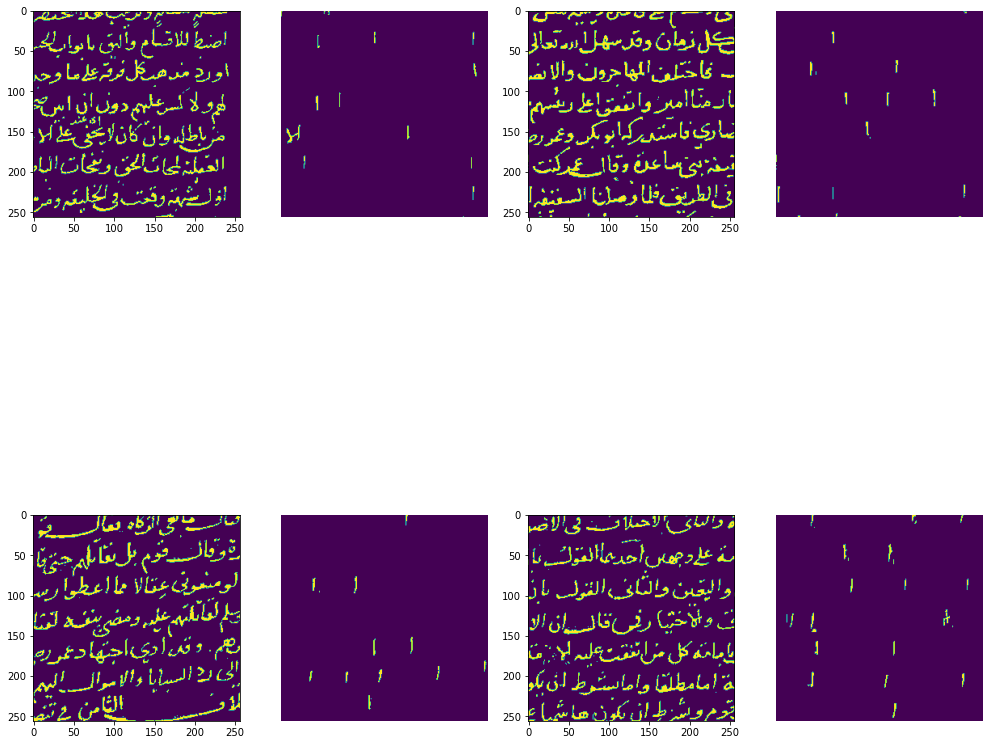

In [19]:
show_batch(tf_image_batch, tf_annot_batch)

In [20]:
model = unet()

In [21]:
model.compile(optimizer=Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

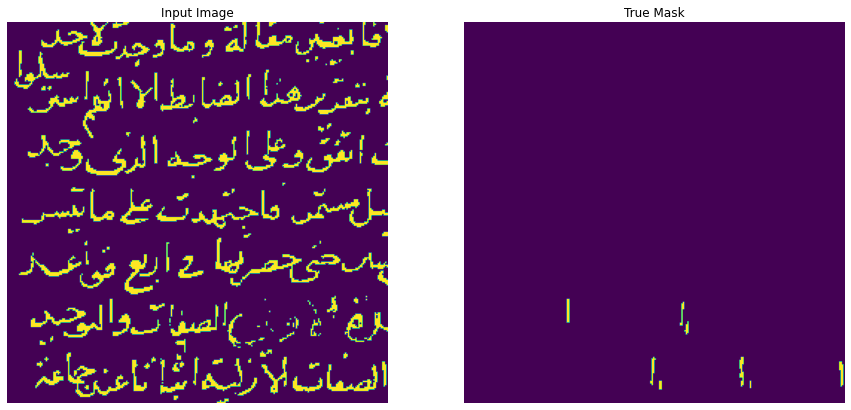

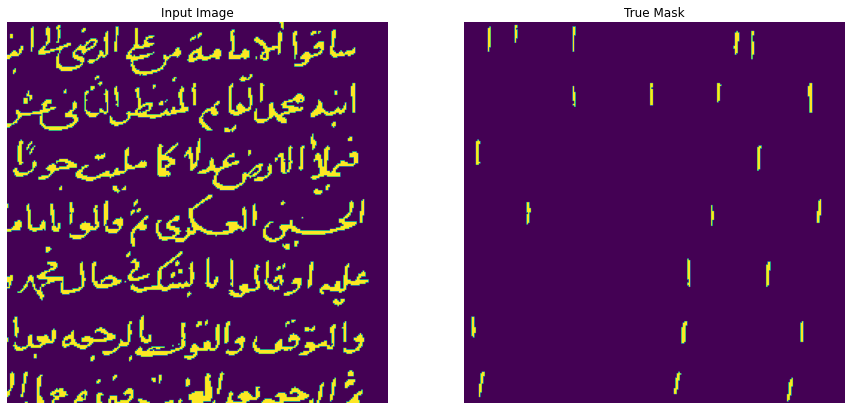

In [23]:
samples = testing_generator.__getitem__(0)
for i in range(2):
    sample_image = samples[0][i]
    sample_mask = samples[1][i]
    display([sample_image, sample_mask])

In [24]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [25]:
def show_predictions():
    display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [26]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [27]:
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint('unet.h5', monitor='val_loss',save_best_only=True,verbose=1)
early_stop_callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


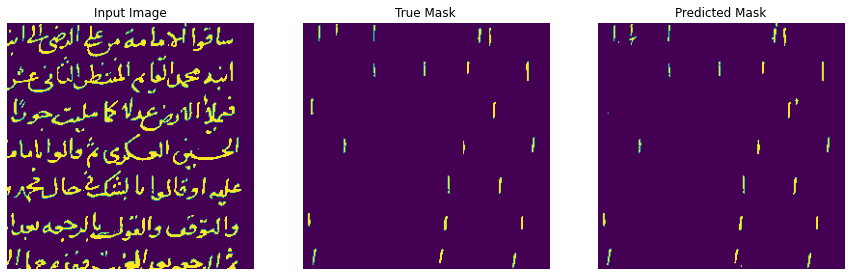


Sample Prediction after epoch 15


Epoch 00015: val_loss did not improve from 0.00747
125/125 [==============================] - 121s 967ms/step - loss: 0.0023 - accuracy: 0.9923 - val_loss: 0.0101 - val_accuracy: 0.9922


In [28]:
model_history = model.fit(training_generator,
                          epochs = epoch_size,
                          steps_per_epoch = train_steps_per_epoch,
                          validation_steps = test_steps_per_epoch,
                          validation_data = testing_generator,
                          callbacks = [DisplayCallback(), early_stop_callback, checkpoint_callback])

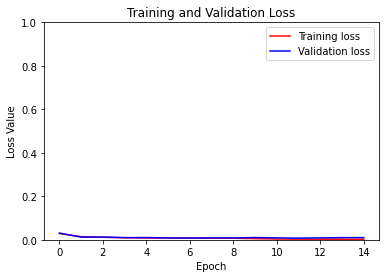

In [29]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [30]:
model = tf.keras.models.load_model('unet.h5')
#results = model.evaluate(training_generator, steps=1)


In [31]:
test_images,test_masks = testing_generator.__getitem__(0)
predict_masks = model.predict(test_images)

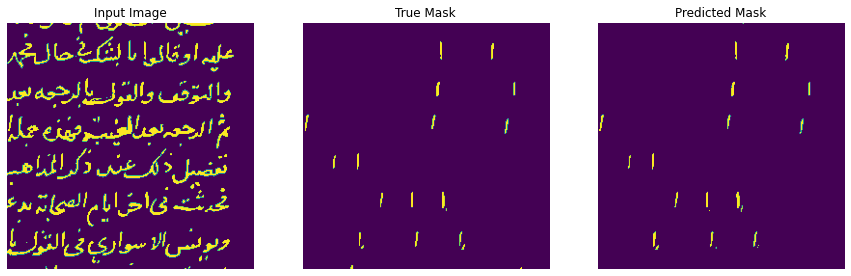

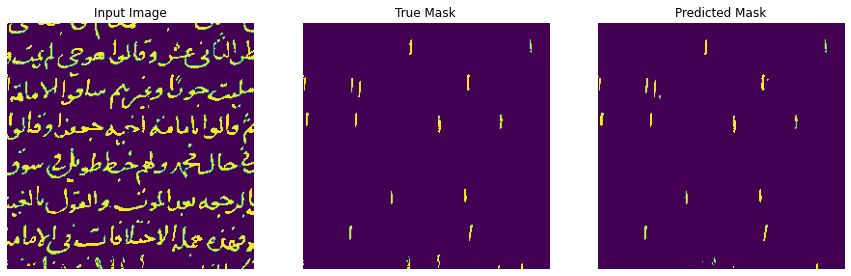

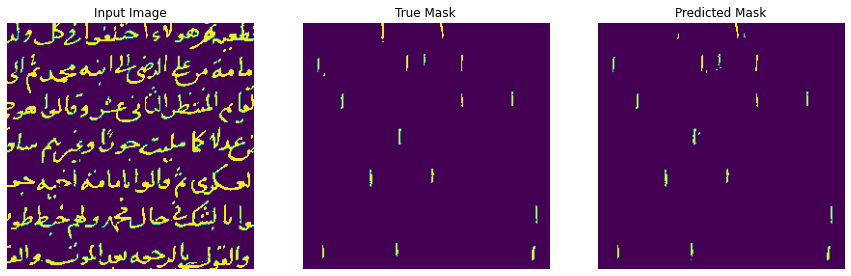

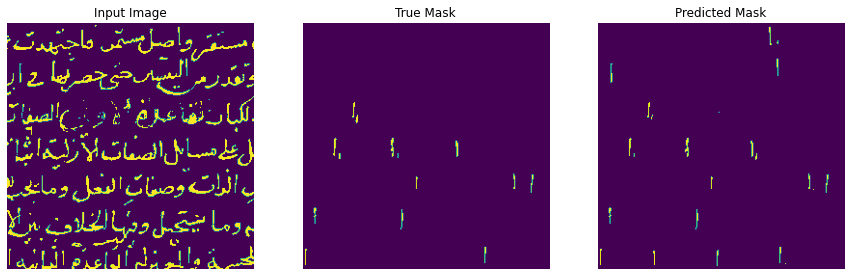

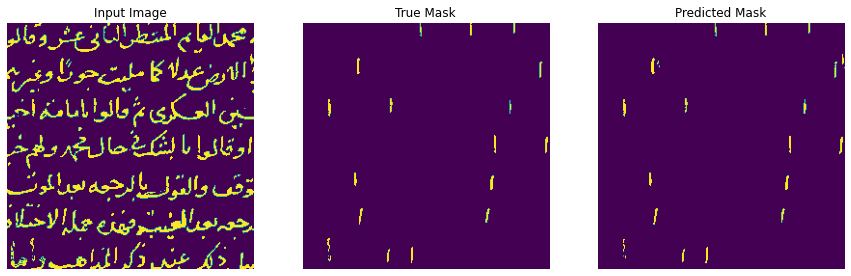

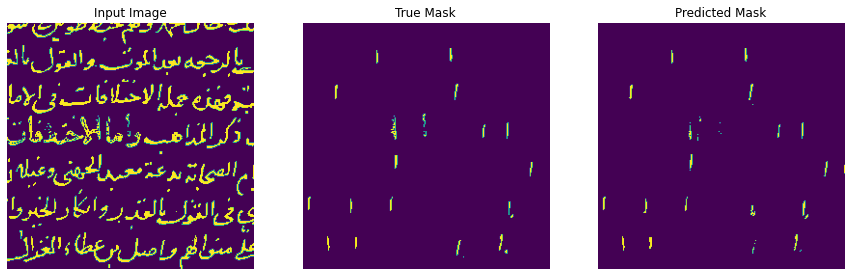

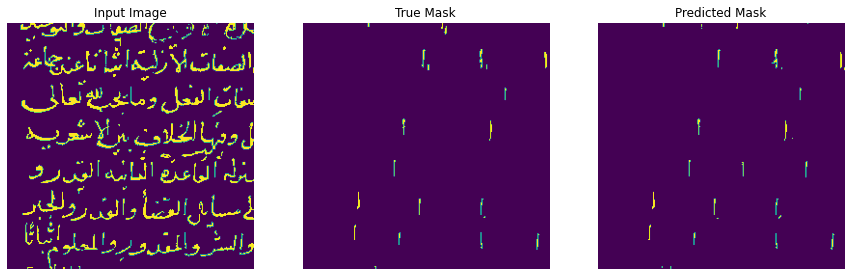

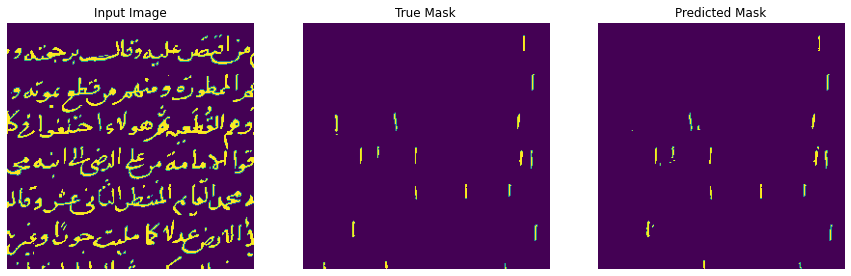

In [32]:
for i in range(len(test_images)):
    predict_mask=tf.argmax(predict_masks[i], axis=-1)
    predict_mask = predict_mask[..., tf.newaxis]
    display([test_images[i], test_masks[i], predict_mask])

In [33]:
def predict(image_patch, model):
    image_patch = normalize(image_patch)
    image_patch = image_patch.reshape(1,image_patch.shape[0], image_patch.shape[1],1)
    predict_mask = model.predict(image_patch)
    predict_mask=tf.argmax(predict_mask, axis=-1)
    predict_mask = predict_mask[..., tf.newaxis]
    predict_mask = predict_mask.numpy()
    predict_mask = predict_mask.reshape(predict_mask.shape[1], predict_mask.shape[2])
    return predict_mask


In [37]:
print('create predicts folder if does not exist')
if not (os.path.exists('predicts')):
    os.mkdir('predicts')

outersize=patch_size
trimsize=28
innersize=outersize-2*trimsize    

c=0
for path in test_align_image_paths:
    page = cv2.imread(path,0)
    rows,cols = page.shape
    x = rows//innersize
    y = cols//innersize
    
    prows=(x+1)*innersize+2*trimsize
    pcols=(y+1)*innersize+2*trimsize
    ppage=np.zeros([prows,pcols])
    ppage[trimsize:rows+trimsize,trimsize:cols+trimsize]=page[:,:]
    pred=np.zeros([rows,cols])
    for i in range(0,prows-outersize,innersize):
        for j in range(0,pcols-outersize,innersize):
            patch=ppage[i:i+outersize,j:j+outersize] 
            ppatch=predict(patch, model)
            pred[i:i+innersize,j:j+innersize]=ppatch[trimsize:trimsize+innersize,trimsize:trimsize+innersize]
    cv2.imwrite('predicts/'+path.split('/')[-1],pred*255)


create predicts folder if does not exist


In [ ]:
np.unique(pred)